In [827]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

#### Ten real-valued features are computed for each cell nucleus:

1) radius (mean of distances from center to points on the perimeter)
2) texture (standard deviation of gray-scale values)
3) perimeter
4) area
5) smoothness (local variation in radius lengths)
6) compactness (perimeter^2 / area - 1.0)
7) concavity (severity of concave portions of the contour)
8) concave points (number of concave portions of the contour)
9) symmetry
10) fractal dimension ("coastline approximation" - 1)

## Checking data and data manipulation

In [828]:
df = pd.read_csv('....\data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [829]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [830]:
df = df.drop(['Unnamed: 32', 'id'], axis = 1)

 Reassigning values in the target column: Convert 'M' to 1 and 'B' to 0

In [831]:
df['diagnosis'] = [1 if i == 'M' else 0 for i in df['diagnosis']]

In [832]:
df['diagnosis'].value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

63 % of observations belong to benign and 37% belong to malignant.

Dealing with outliers

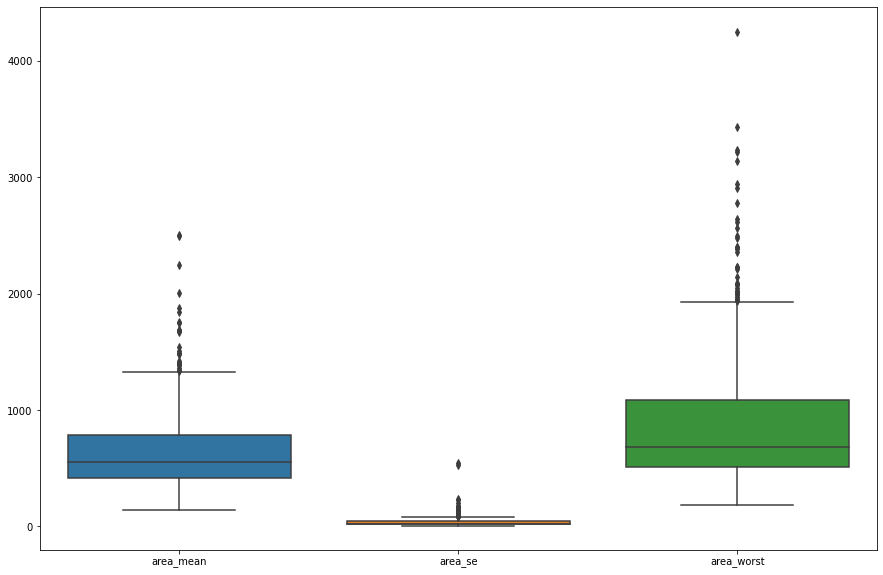

In [833]:
area_measurement = ['area_mean', 'area_se', 'area_worst']
plt.figure(figsize=(15, 10))
sns.boxplot(data = df[area_measurement])
plt.show()

In [834]:
def deal_outliers(x):
    if x > upper_threshold:
      return upper_threshold
    return x

In [835]:
for a in area_measurement:
    quantile_1 = np.quantile(df[a],0.25)
    quantile_3 = np.quantile(df[a],0.75)
    IQR = quantile_3 - quantile_1
    upper_threshold = quantile_3 + 1.5 * IQR
    df[a] = df[a].apply(deal_outliers)


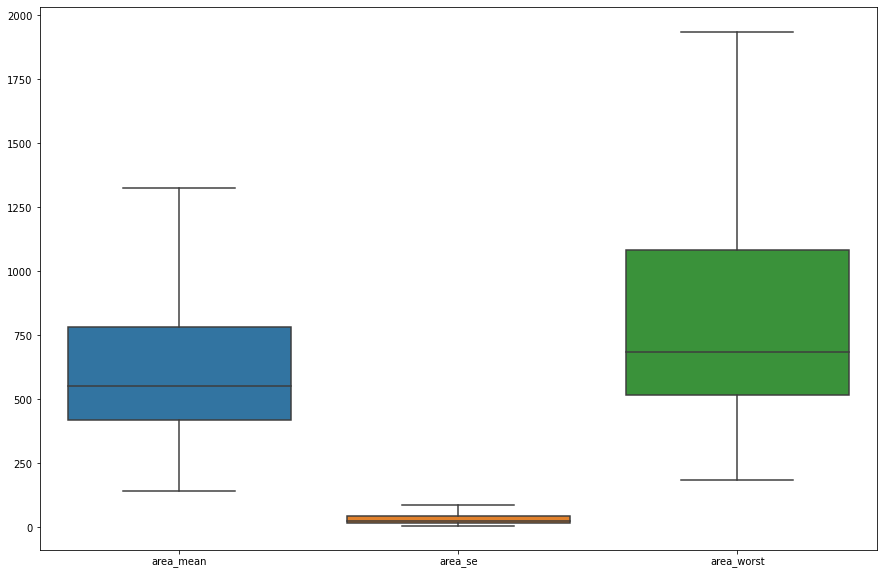

In [836]:
plt.figure(figsize=(15, 10))
sns.boxplot(data = df[area_measurement])
plt.show()

## Exploratory data analysis

In [837]:
diagnosis_corr = df.corr()['diagnosis'].sort_values()

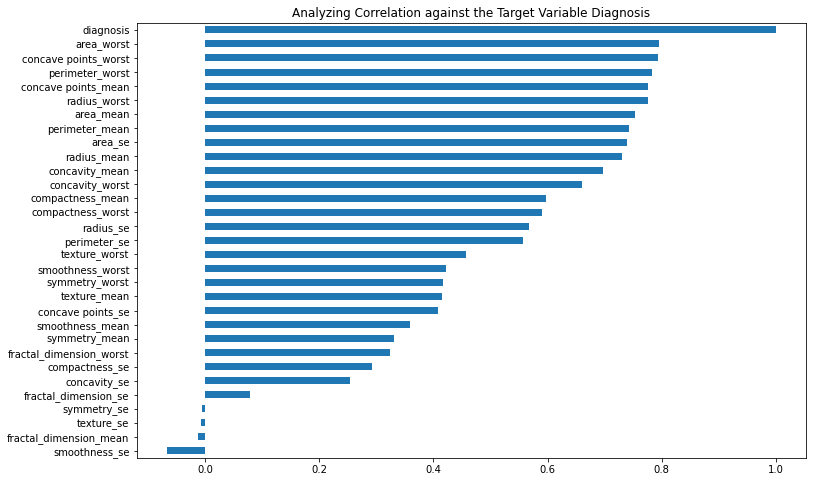

In [838]:
plt.figure(figsize=(12, 8))
diagnosis_corr.plot(kind = 'barh')
plt.title('Analyzing Correlation against the Target Variable Diagnosis')
plt.show()

There is a big positive correlation between diagnosis and area, the number of concave portions of the contour, and the perimeter. 

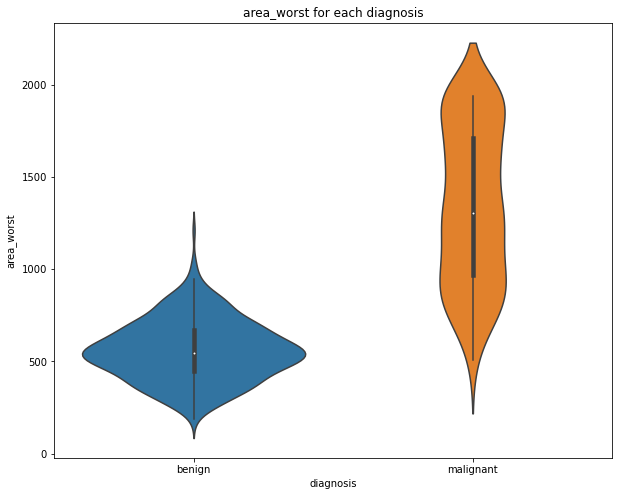

In [839]:
plt.figure(figsize=(10, 8))
sns.violinplot(data=df,x='diagnosis',y='area_worst')
plt.title('area_worst for each diagnosis')
plt.xticks([0,1], ['benign','malignant'])
plt.show()

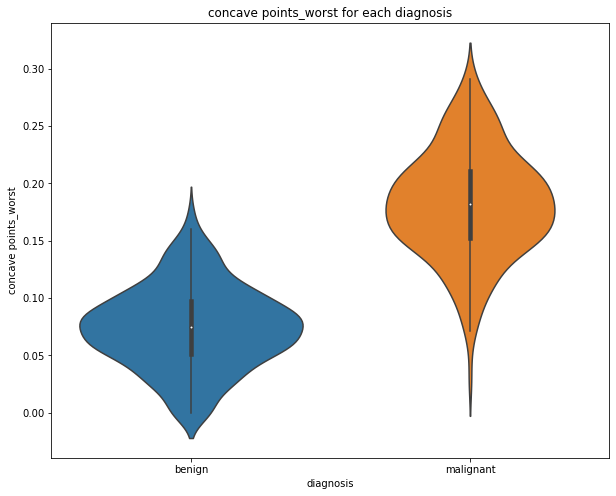

In [840]:
plt.figure(figsize=(10, 8))
sns.violinplot(data=df,x='diagnosis',y='concave points_worst')
plt.title('concave points_worst for each diagnosis')
plt.xticks([0,1], ['benign','malignant'])
plt.show()

It is noticeable that both violin plots have different patterns of the categories. Approximately, when the 1.5x interquartile range ends at benign, the interquartile range for malignant only starts. The malignant category also has more outliers while benign has a rounded shape meaning that a higher probability that values of the population are taken on at the interquartile range. 

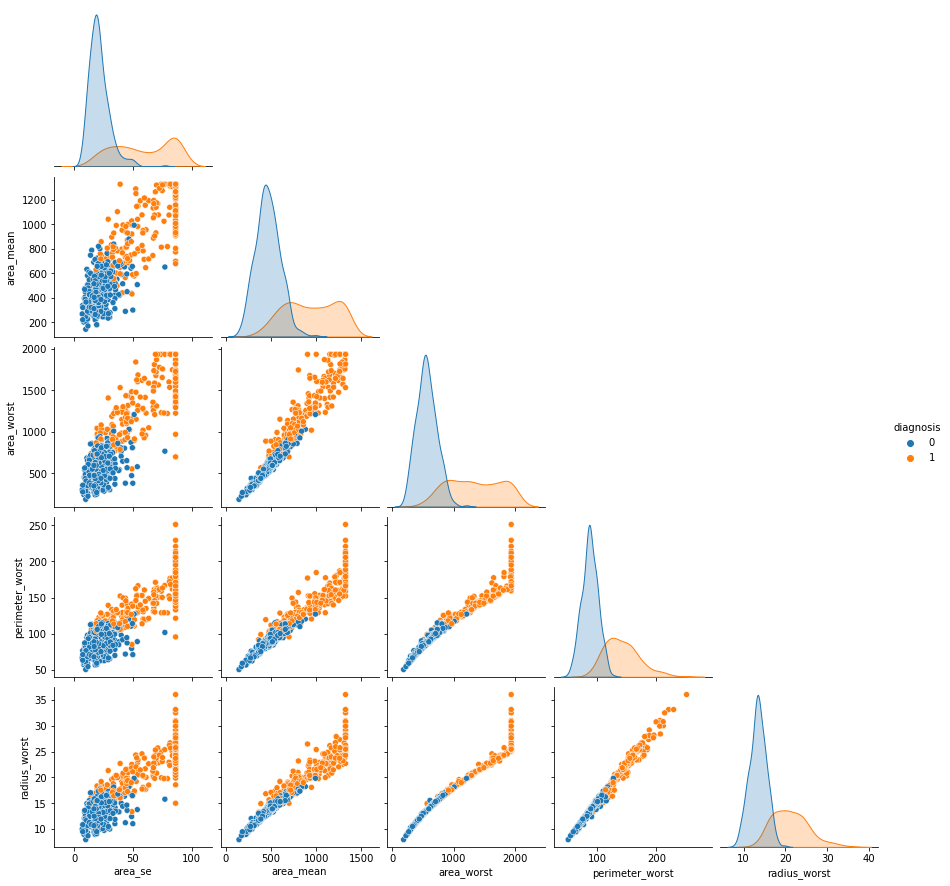

In [841]:
sns.pairplot(df[['diagnosis','area_se','area_mean','area_worst','perimeter_worst','radius_worst']],hue='diagnosis', corner=True)
plt.show()

Greater measurements in terms of area, radius, and perimeter are indicative of cases associated with malignant cancer.

## Data Splitting and Feature Scaling

In [842]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.297676,1.097064,-2.073335,1.269934,1.184085,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.287627,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.297676,1.829821,-0.353632,1.685955,2.249396,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,2.287627,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.297676,1.579888,0.456187,1.566503,1.846217,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.807751,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,1.297676,-0.768909,0.253732,-0.592687,-0.831485,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.593838,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.297676,1.750297,-1.151816,1.776573,2.154338,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.525780,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


Using the StandardScaler for improving the accuracy.

In [843]:
X = np.array(scaled_df.iloc[:, 1:])
y = np.array(df['diagnosis']).reshape(-1,1)

In [844]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)


## K-Nearest Neighbors (KNN)

In [845]:
knn = KNeighborsClassifier(n_neighbors= 9)
knn.fit(X_train, y_train.ravel())
k_pred = knn.predict(X_test)
knn.score(X_test, y_test)

0.9883040935672515

In [846]:
confusion_matrix(y_test, k_pred)

array([[111,   1],
       [  1,  58]], dtype=int64)

In [847]:
print(classification_report(y_test, k_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       112
           1       0.98      0.98      0.98        59

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



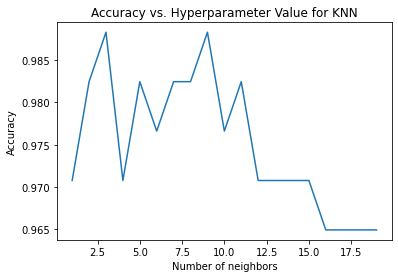

In [848]:
score_list = []
for each in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors=each)
    knn2.fit(X_train,y_train.ravel())
    score_list.append(knn2.score(X_test,y_test))
    
plt.plot(range(1,20),score_list)
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title('Accuracy vs. Hyperparameter Value for KNN')
plt.show()

The accuracy is 99 percent, 1 value is False-Negative and 1 value is False Positive, high precision and recall. To sum up, it is a very accurate model, which was obtained by tuning hyperparameters and feature scaling.

## Logistic Regression

In [849]:
logistic = LogisticRegression(C = 0.1)
logistic.fit(X_train, y_train.ravel())
l_pred = logistic.predict(X_test)
logistic.score(X_test, y_test)

0.9824561403508771

In [850]:
confusion_matrix(y_test, l_pred)

array([[110,   2],
       [  1,  58]], dtype=int64)

In [851]:
print(classification_report(y_test, l_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       112
           1       0.97      0.98      0.97        59

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



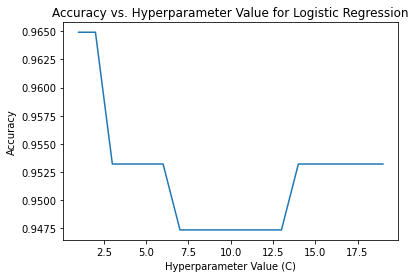

In [852]:
score_list01 = []
for each in range(1, 20):
    log_reg = LogisticRegression(C=each)
    log_reg.fit(X_train, y_train.ravel())
    score_list01.append(log_reg.score(X_test, y_test))
    
plt.plot(range(1, 20), score_list01)
plt.xlabel("Hyperparameter Value (C)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Hyperparameter Value for Logistic Regression")
plt.show()

The accuracy is 98 percent, False-Negative - 1 and False Positive - 2, high precision and recall. To sum up, it is an accurate model, which was obtained by tuning hyperparameters and feature scaling.

## Support Vector Machines

In [853]:
svc = SVC(C = 5) 
svc.fit(X_train, y_train.ravel())
svc_pred = svc.predict(X_test)
svc.score(X_test, y_test)

0.9883040935672515

In [854]:
confusion_matrix(y_test, svc_pred)

array([[110,   2],
       [  0,  59]], dtype=int64)

In [855]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       112
           1       0.97      1.00      0.98        59

    accuracy                           0.99       171
   macro avg       0.98      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



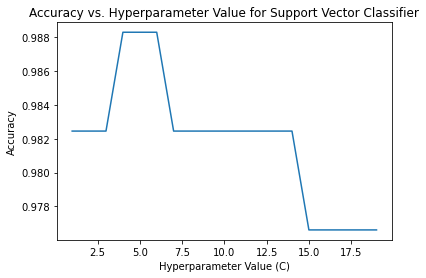

In [856]:
score_list02 = []
for each in range(1, 20):
    svc_model = SVC(C=each)
    svc_model.fit(X_train, y_train.ravel())
    score_list02.append(svc_model.score(X_test, y_test))

plt.plot(range(1, 20), score_list02)
plt.xlabel("Hyperparameter Value (C)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Hyperparameter Value for Support Vector Classifier")
plt.show()

The accuracy is 99 percent, False-Negative - 0 and False Positive - 2, high precision and recall. To sum up, it is a very accurate model, which was obtained by tuning hyperparameters and feature scaling.

## Decision Tree

In [857]:
dtc = DecisionTreeClassifier(max_depth=5, random_state= 20)
dtc.fit(X_train, y_train.ravel())
dtc_pred = dtc.predict(X_test)
dtc.score(X_test, y_test)

0.935672514619883

In [858]:
confusion_matrix(y_test, dtc_pred)

array([[107,   5],
       [  6,  53]], dtype=int64)

In [859]:
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       112
           1       0.91      0.90      0.91        59

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



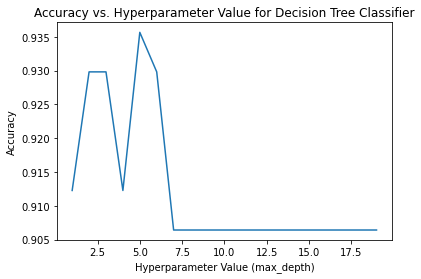

In [860]:
score_list03 = []

for each in range(1, 20):
    dt_model = DecisionTreeClassifier(max_depth=each, random_state= 20)
    dt_model.fit(X_train, y_train.ravel())
    score_list03.append(dt_model.score(X_test, y_test))

plt.plot(range(1, 20), score_list03)
plt.xlabel("Hyperparameter Value (max_depth)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Hyperparameter Value for Decision Tree Classifier")
plt.show()

The accuracy is 94 percent, False-Negative - 6 and False Positive - 5, lower precision and recall. So far it is  the worst model from all our models.

## Random Forest

In [861]:
rfc = RandomForestClassifier(random_state= 20)
rfc.fit(X_train, y_train.ravel())
rfc_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.9824561403508771

In [862]:
confusion_matrix(y_test, rfc_pred)

array([[109,   3],
       [  0,  59]], dtype=int64)

In [863]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       112
           1       0.95      1.00      0.98        59

    accuracy                           0.98       171
   macro avg       0.98      0.99      0.98       171
weighted avg       0.98      0.98      0.98       171



The accuracy is 98 percent, False-Negative - 0 and False Positive - 3, high precision and recall. To sum up, it is an accurate model.